In [38]:
from IPython.display import clear_output

In [39]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
print(f'{len(train_dataset)=}')
print(f'{len(test_dataset)=}')

len(train_dataset)=50000
len(test_dataset)=10000


label=71


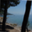

In [42]:
img, label = test_dataset[10]
print(f'{label=}')
transforms.functional.to_pil_image(img)

# Procedure

1. Train a custom CNN classifier for CIFAR100 dataset.
2. Draw a graph to show the drop in losses (train loss and val loss) during the training.
2. After training on train data, do validation on test_data and show the overall accuracy of the model.
3. Also show label wise performance/accuracy of the model.

In [43]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

In [44]:
batch_sz = 64
train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

In [45]:
class CNN(nn.Module):
  def __init__(self, nf1, nf2, nf3, nh, no):
    super().__init__()
    self.conv1 = nn.Conv2d(3, nf1, 3, 1, 1)
    self.conv2 = nn.Conv2d(nf1, nf2, 3, 1, 1)
    self.conv3 = nn.Conv2d(nf2, nf3, 3, 1, 1)
    self.fc1 = nn.Linear(nf3*4*4,nh)
    self.fc2 = nn.Linear(nh, no)
    self.nf3 = nf3

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = F.max_pool2d(x, (2,2))

    x = self.conv2(x)
    x = torch.relu(x)
    x = F.max_pool2d(x, (2,2))

    x = self.conv3(x)
    x = torch.relu(x)
    x = F.max_pool2d(x, (2,2))

    x = x.view(-1, self.nf3 * 4 * 4)
    x = self.fc1(x)
    x = torch.relu(x)

    x = self.fc2(x)
    return x

In [46]:
device = "cuda:0"
num_epochs = 10
lr = 1e-4

train_losses = []
val_losses = []
lebels_corr = [0 for i in range(100)]
lebels_len = [0 for i in range(100)]
model = CNN(10, 25, 50, 300, 100)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model = model.to(device)
print(f'Using device {device}')

Using device cuda:0


In [47]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0
  for batch in train_loader:

    batch_X, batch_y = batch[0].to(device), batch[1].to(device)  # convert to [N, 28*28] shape where N is batch_size

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs,batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later


  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients
    val_epoch_weighted_loss = 0

    for batch in test_loader:

      val_batch_X, val_batch_y = batch[0].to(device), batch[1].to(device)  # convert to [N, 28*28] shape where N is batch_size


      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

      expected = val_batch_y_pred.tolist()
      actual = val_batch_y.tolist()
      for e, a in zip(expected, actual):
        lebels_len[e] += 1
        if e == a:
          lebels_corr[e]+=1


  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')


Epoch: 0, train_loss=4.318577301864624, val_loss=4.050490193939209. labelled 868/10000 correctly (8.68% accuracy)
Epoch: 1, train_loss=3.9313726457214355, val_loss=3.876405551147461. labelled 1126/10000 correctly (11.26% accuracy)
Epoch: 2, train_loss=3.794888529510498, val_loss=3.766624179840088. labelled 1342/10000 correctly (13.420000000000002% accuracy)
Epoch: 3, train_loss=3.6835869326782227, val_loss=3.6638094764709472. labelled 1561/10000 correctly (15.61% accuracy)
Epoch: 4, train_loss=3.568212791290283, val_loss=3.550462762451172. labelled 1729/10000 correctly (17.29% accuracy)
Epoch: 5, train_loss=3.457478614730835, val_loss=3.458633088684082. labelled 1909/10000 correctly (19.09% accuracy)
Epoch: 6, train_loss=3.37789310256958, val_loss=3.3971128299713134. labelled 2015/10000 correctly (20.150000000000002% accuracy)
Epoch: 7, train_loss=3.3177215637969972, val_loss=3.3500096603393557. labelled 2071/10000 correctly (20.71% accuracy)
Epoch: 8, train_loss=3.2661228577423094, va

In [48]:
for i in range(len(lebels_corr)):
  if lebels_len[i] != 0:
    print(f"Label: {i} accuracy = {lebels_corr[i]*100/(lebels_len[i])}%")
  else:
    print(f"Label: {i} has not been included in the testing set")


Label: 0 accuracy = 34.883720930232556%
Label: 1 accuracy = 14.320154291224686%
Label: 2 accuracy = 16.071428571428573%
Label: 3 accuracy = 12.080536912751677%
Label: 4 accuracy = 9.67741935483871%
Label: 5 accuracy = 9.426229508196721%
Label: 6 accuracy = 16.847826086956523%
Label: 7 accuracy = 17.32851985559567%
Label: 8 accuracy = 28.571428571428573%
Label: 9 accuracy = 29.313929313929314%
Label: 10 accuracy = 12.994350282485875%
Label: 11 accuracy = 5.46875%
Label: 12 accuracy = 12.090680100755668%
Label: 13 accuracy = 8.871794871794872%
Label: 14 accuracy = 9.72644376899696%
Label: 15 accuracy = 7.75058275058275%
Label: 16 accuracy = 14.534883720930232%
Label: 17 accuracy = 27.37127371273713%
Label: 18 accuracy = 23.26283987915408%
Label: 19 accuracy = 18.51851851851852%
Label: 20 accuracy = 19.71027216856892%
Label: 21 accuracy = 16.67834618079888%
Label: 22 accuracy = 39.583333333333336%
Label: 23 accuracy = 37.75401069518717%
Label: 24 accuracy = 20.750921890714046%
Label: 25 a

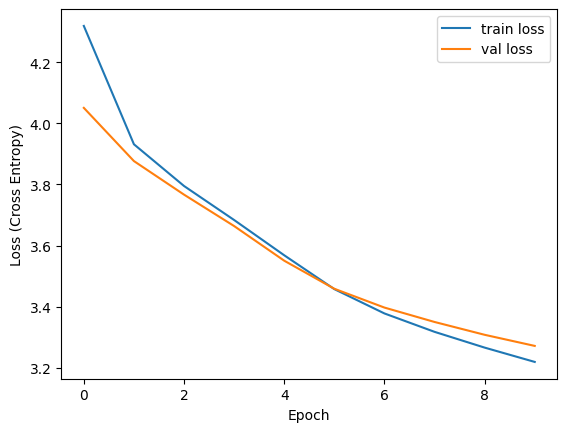

In [49]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()